In [1]:
#Code qui lance la webcam live
import cv2

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    exit()

while True:
    ret, frame = cap.read()
    if ret:
        cv2.imshow("Webcam Live", frame)

    # Quitter avec q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(100)

-1

In [5]:
# fonction qui détecte les markers ArUco
def detect_aruco(frame):
    # Prépare le dictionnaire ArUco
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
    # Convertir en gris
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # detect markers
    corners, ids, rejected = detector.detectMarkers(gray)

    # copy for visualization
    vis = frame.copy()
    if ids is not None:
        cv2.aruco.drawDetectedMarkers(vis, corners, ids)
    return corners, ids, rejected, vis

IDs détectés : [[3]
 [4]
 [0]
 [1]
 [2]]


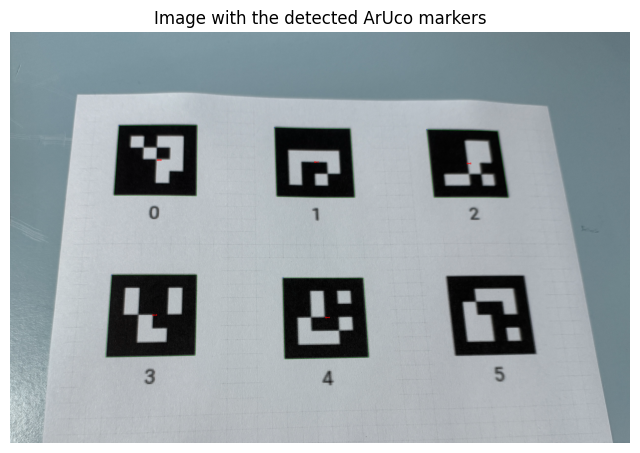

In [6]:
# Code qui affiche la détection ArUco à partir d'un fichier jpg
import cv2
import matplotlib.pyplot as plt
image_path = 'markers.jpg'
image = cv2.imread(image_path)


# Détection ArUco
corners, ids, rejected, vis = detect_aruco(image)

# Afficher résultat
print("IDs détectés :", ids)

plt.figure(figsize=(8, 6))
plt.imshow(vis, cmap='hsv') # Important: utiliser cmap='gray' pour les images N&B
plt.title("Image with the detected ArUco markers")
plt.axis('off') # Cache les axes x et y
plt.show() # Affiche la fenêtre Matplotlib


In [7]:
# Code qui affiche la détection ArUco en live via la webcam
import cv2
import numpy as np

# Ouvre la webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Erreur : impossible d'ouvrir la webcam")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Détecter les marqueurs
    corners, ids, rejected, vis = detect_aruco(frame)

    # Afficher la frame en live
    cv2.imshow("Webcam - ArUco Detection Live", vis)

    # Quitter avec 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(100)


-1

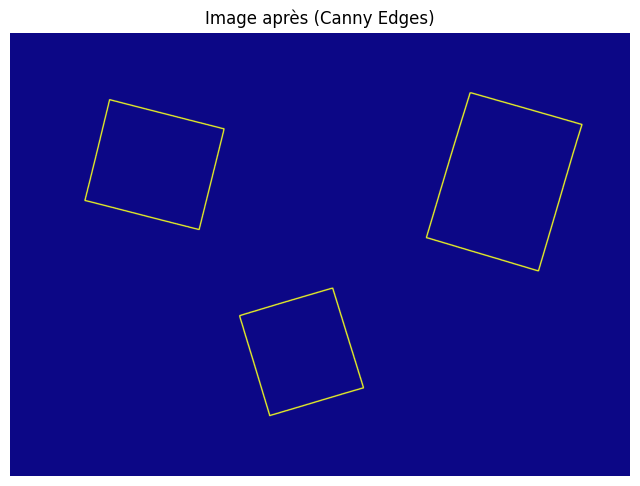

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    """Convertit l'image en niveaux de gris, applique un flou et une détection de contours."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    edges = cv2.Canny(blurred, 90, 200, 7, L2gradient=True)
    return edges

# --- Utilisation ---

image_path = 'obstacles.jpg' # Remplacer par le chemin de mon image
image = cv2.imread(image_path)

edges = preprocess_image(image)
dilated_edges = cv2.dilate(edges, kernel=np.ones((5, 5), np.uint8), iterations=1)

plt.figure(figsize=(8, 6))
plt.imshow(dilated_edges, cmap='plasma') 
plt.title("Image après (Canny Edges)")
plt.axis('off') # Cache les axes x et y
plt.show() # Affiche la fenêtre Matplotlib


Liste des vertices :
[array([[1526, 1005],
       [ 892, 1191],
       [1096, 1870],
       [1733, 1683]], dtype=int32), array([[ 344,  155],
       [ 178,  839],
       [ 955, 1036],
       [1123,  352]], dtype=int32), array([[1992,   71],
       [1697, 1053],
       [2459, 1277],
       [2753,  284]], dtype=int32)]


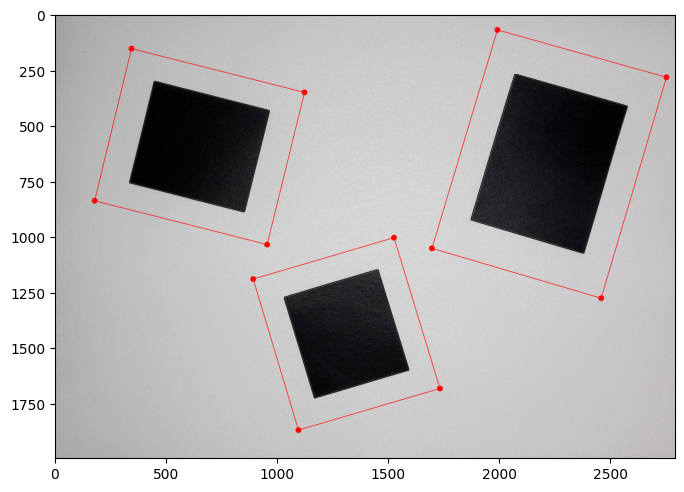

In [3]:
def scale_contour(contour, scale):
    M = cv2.moments(contour)
    if M['m00'] == 0:
        return contour
    
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    center = np.array([cx, cy])
    
    scaled = (contour - center) * scale + center
    return scaled.astype(np.int32)


# --- Utilisation ---

contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

scaled_contours = []
all_vertices = []
output = image.copy()
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    scaled = scale_contour(approx, scale=1.5)
    scaled_contours.append(scaled)

    vertices = scaled.reshape(-1, 2)   # (4,2)
    all_vertices.append(vertices)
    for (x, y) in vertices:
        cv2.circle(output, (x, y), 13, (0, 0, 255), -1)


cv2.drawContours(output, contours, -1, (0, 0, 0), 2)
cv2.drawContours(output, scaled_contours, -1, (0, 0, 255), 2)

print("Liste des vertices :")
print(all_vertices)

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.show()


Chemin trouvé = [0, 1, 8, 5, 13]


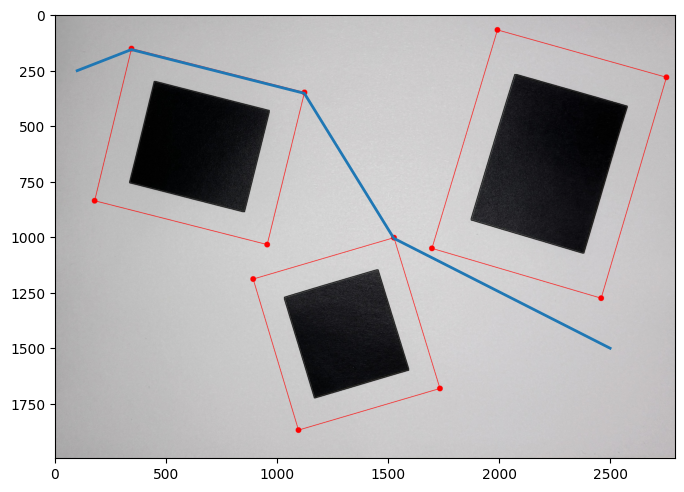

In [ ]:
# Algo A-star pour le pathfinding à partir des vertices

import heapq
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Distance ------------------

def dist(a, b):
    return np.linalg.norm(a - b)

# ------------------ Geometry: intersection checks ------------------

def ccw(A, B, C):
    # True if A->B->C turns CounterClockWise
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

def segment_intersect(A, B, C, D):
    # Check if segment AB intersects segment CD
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

def segment_intersects_polygon(p1, p2, poly):
    # poly: array of shape (N,2)
    N = len(poly)
    for i in range(N):
        A = poly[i]
        B = poly[(i+1) % N]
        if segment_intersect(p1, p2, A, B):
            return True
    return False

def is_blocked(p1, p2, obstacles):
    # obstacles: list of polygons (each polygon is Nx2)
    for poly in obstacles:
        if segment_intersects_polygon(p1, p2, poly):
            return True
    return False

# ------------------ A* search ------------------

def astar(points, start, goal, obstacles):
    N = len(points)

    g = {i: float('inf') for i in range(N)}
    g[start] = 0

    f = {i: float('inf') for i in range(N)}
    f[start] = dist(points[start], points[goal])

    came_from = {}
    open_set = []
    heapq.heappush(open_set, (f[start], start))

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            # reconstruct path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]

        for neighbor in range(N):

            if neighbor == current:
                continue

            # empêcher start → goal direct
            if current == start and neighbor == goal:
                continue

            # Reject edges that cross obstacles
            if is_blocked(points[current], points[neighbor], obstacles):
                continue

            cost = dist(points[current], points[neighbor])
            tentative_g = g[current] + cost

            if tentative_g < g[neighbor]:
                came_from[neighbor] = current
                g[neighbor] = tentative_g
                f[neighbor] = tentative_g + dist(points[neighbor], points[goal])
                heapq.heappush(open_set, (f[neighbor], neighbor))

    return None

# ------------------ Build point set ------------------

start = np.array([2500, 1500])
goal  = np.array([100, 250])

# points = all obstacle vertices
points = np.vstack(all_vertices)

# full point list: start + obstacle vertices + goal
full_points = np.vstack([start, points, goal])

start_idx = 0
goal_idx = len(full_points) - 1

# ------------------ Run A* ------------------

path = astar(full_points, start_idx, goal_idx, all_vertices)
print("Chemin trouvé =", path)

# ------------------ Visualisation ------------------

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis('on')

if path is not None:
    path_pts = full_points[path]
    plt.plot(path_pts[:,0], path_pts[:,1], linewidth=2)

plt.show()
